# Self Driving Car Nano Degree - Term 1 - Project 1: Finding Lane Lines
__Author:__ James Milam  
__Term Start Date:__ March 15, 2018

## Import Packages and set up Environment

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# Determine the path to the supplied images
image_dir = "test_images/"
images = [image_dir + i for i in os.listdir(image_dir)]

# Determine the path to the supplied videos and the location
# to place video output
video_dir = "test_videos/"
videos = [video_dir + i for i in os.listdir(video_dir)]
video_output_dir = "test_videos_output/"
video_outputs = [video_output_dir + i for i in os.listdir(video_dir)]

## Create a function to process the images
This function will be used on the test images and the test videos

In [2]:
def process_image(image):
    """This function will take a loaded image and use lane detection
    techniques to determine where the lane lines are in the image.
    
    Parameters
    ==========
    
    image: matplotlib.image
        This is the input image to be processed
    
    Returns
    =======
    
    imGBlur: matplotlib.image
        This is the original image with Gaussian blurring applied
    imGray: matplotlib.image
        This is the Gaussian blurred image transformed to grayscale
    imColor: matplotlib.image
        This is the grayscale image with thresholds applied to remove
        the dark areas 
    imCanny: matplotlib.image
        This is an image produced by using Canny edge detection on the
        brightness threshold image
    imRMaskL: matplotlib.image
        This is an image produced by region masking the left lane area of
        the Canny edge detection video
    imRMaskR: matplotlib.image
        This is an image produced by region masking the right lane area of
        the Canny edge detection video
    imHough: matplotlib.image
        This is a copy of the original image with the detected lanes
        highlighted using the Hough lines
    result: matplotlib.image
        This is a copy of the original image with the detected lanes
        highlighted using the averaged and extrapolated lines
    """
    
    imCopy = np.copy(image)

    
    # GAUSSIAN BLUR
    # A slight Gaussian blur is applied to the original image
    kernel_size = 3
    imGBlur = cv2.GaussianBlur(imCopy, (kernel_size, kernel_size), 0)
    

    # BRIGHTNESS PROCESSING:
    # First the image is converted to gray so that yellow and white line
    # can be picked off by a threshold. Next use a threshold to filter
    # out the darker regions of the image.
    imGray = cv2.cvtColor(imGBlur, cv2.COLOR_RGB2GRAY)
    thresholds = (image[:,:,0] < 140) 
    imColor = np.copy(imGray)
    imColor[thresholds] = [0]
    
    
    # CANNY EDGE DETECTION
    # The Canny edge detection method is used to highlight the exterior of
    # the lines.
    low_threshold = 50
    high_threshold = 150
    imCanny = cv2.Canny(imColor, low_threshold, high_threshold)
    
    
    # REGION MASKING:
    # First define the vertices of the region that should be kept. 
    # This region is defined as percentages of the overall image 
    # size to allow for different sized images to be used. Then the
    # rest of the image is blacked out leaving just the region of
    # interest. This is done to separate left and right lanes as well
    imshape = image.shape
    left_vertices = np.array([[(0.13*imshape[1], imshape[0]),
                               (0.465*imshape[1], 0.6*imshape[0]),
                               (0.50*imshape[1], 0.6*imshape[0]),
                               (0.5*imshape[1], imshape[0])]], dtype=np.int32)
    right_vertices = np.array([[(0.5*imshape[1], imshape[0]),
                                (0.5*imshape[1], 0.6*imshape[0]),
                                (0.55*imshape[1], 0.6*imshape[0]),
                                (0.93*imshape[1], imshape[0])]], dtype=np.int32)
    mask_L = np.zeros_like(imCanny)
    mask_R = np.zeros_like(imCanny)
    cv2.fillPoly(mask_L, left_vertices, [255, 255, 255])
    cv2.fillPoly(mask_R, right_vertices, [255, 255, 255])
    imRMaskL = cv2.bitwise_and(imCanny, mask_L)
    imRMaskR = cv2.bitwise_and(imCanny, mask_R)
    
    
    # Hough Transform
    # A function is used to perform the Hough transform to reduce code redundancy
    # when performing the operations on left and right lane images
    def hough_lin_reg(raw, image):
        """This function will perform a hough transform and a linear
        regression on the lines that are produced to create averaged lines.
        
        Parameters
        ==========
        
        raw: matplotlib.image
            This is the unprocessed original image
        image: matplotlib.image
            This is the image to perform the Hough transform on
        
        Returns
        =======
        
        hough_lines: matplotlib.image
            This image is the hough lines drawn on a blank image the same size as
            the unprocessed original image
        line_image: matplotlib.image
            This image is two averaged and extrapolated lines using a linear
            regression on the points that are returned by the Hough transform
        """
    
        # Set up the parameters that will be needed for the Hough transformation and
        # create blanks to draw the results on
        rho = 2 
        theta = np.pi/180 
        threshold = 15
        min_line_length = 28
        max_line_gap = 15
        line_image = np.copy(raw)*0
        hough_lines = np.copy(raw)*0

        # Run Hough on edge detected image
        # Output "lines" is an array containing endpoints of detected line segments
        lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]),
                                    min_line_length, max_line_gap)

        # Iterate over the output "lines" and draw lines on a blank image. Also
        # collect the points associated with the Hough transform
        x = []
        y = []
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(hough_lines, (x1, y1), (x2, y2), (255,0,0), 3)
                x.append(x1)
                x.append(x2)
                y.append(y1)
                y.append(y2)
                

        # Use least squares linear regression on the points produced by the
        # Hough transform to create an averaged and extrapolated prediction
        # of where the lane lines are.
        n = len(x)
        xy = [x[i]*y[i] for i in range(n)]
        xsquared = [i**2 for i in x]
        
        sumx = np.sum(x)
        sumy = np.sum(y)
        sumxy = np.sum(xy)
        sumxsquared = np.sum(xsquared)
        
        slope = (n*sumxy - sumx*sumy)/(n*sumxsquared - (sumx)**2)
        b = (sumy - slope*sumx)/n
        
        y1 = int(image.shape[0]*0.6)
        x1 = int((y1 - b)/slope)
        y2 = int(image.shape[0])
        x2 = int((y2 - b)/slope)
        
        # Draw the result of the least squares linear regression on the
        # blank image
        cv2.line(line_image, (x1, y1), (x2, y2), (255,0,0), 10)
        
        return hough_lines, line_image

    # Use the hough_lin_reg function on the left and right lane region masked
    # images and draw the results over the a copy of the original image.
    hough_lines_L, line_image_L = hough_lin_reg(image, imRMaskL)
    hough_lines_R, line_image_R = hough_lin_reg(image, imRMaskR)
    
    imcopy = np.copy(image)    
    imHough = cv2.addWeighted(imcopy, 0.8, hough_lines_L, 1, 0)
    imHough = cv2.addWeighted(imHough, 1, hough_lines_R, 1, 0)

    imcopy = np.copy(image)       
    result = cv2.addWeighted(imcopy, 0.8, line_image_L, 1, 0)
    result = cv2.addWeighted(result, 1, line_image_R, 1, 0)
    
    return [imGBlur, imGray, imColor, imCanny, imRMaskL, imRMaskR, imHough, result]

## Stepping through the process
This set of code will display each step of the procedure in `process_image()` applied to a single image.

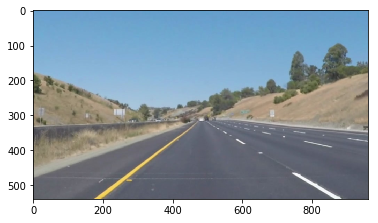

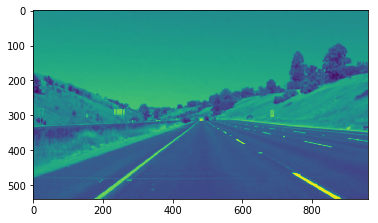

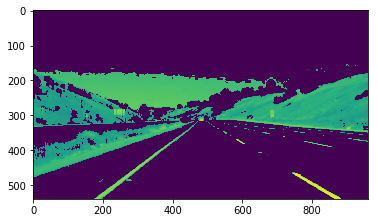

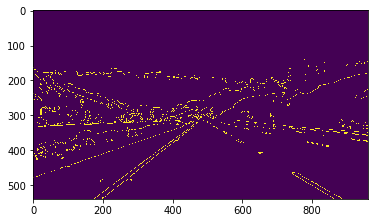

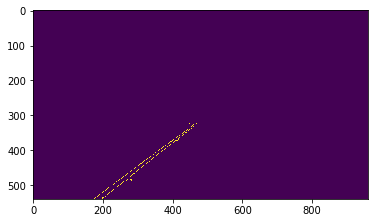

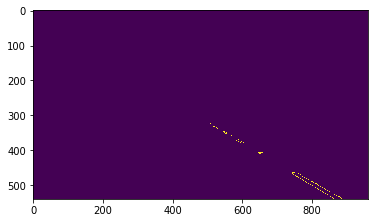

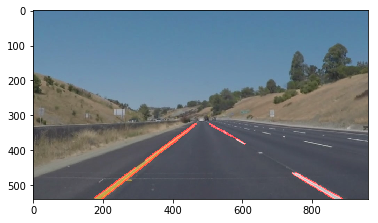

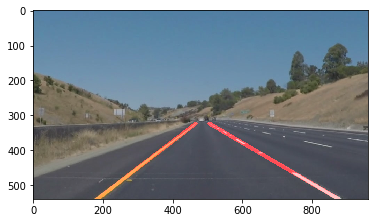

In [3]:
test_image = mpimg.imread(images[-1])
test_results = process_image(test_image)
for i in test_results:
    plt.figure()
    plt.imshow(i)

## Run the process function on the supplied images
The `process_image()` function will now be tested on the rest of the images and just return the averaged and extrapolated lines

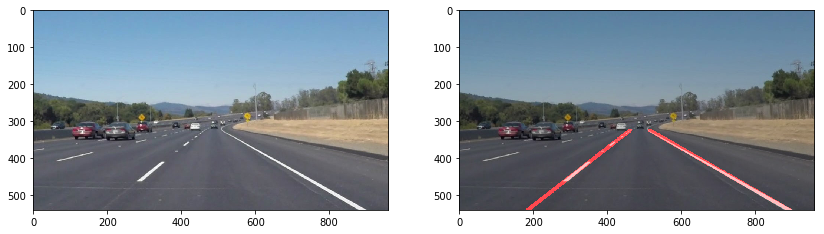

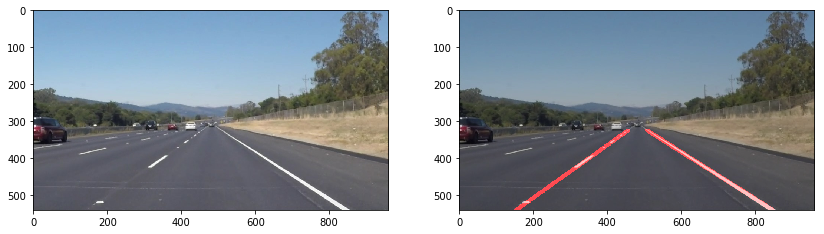

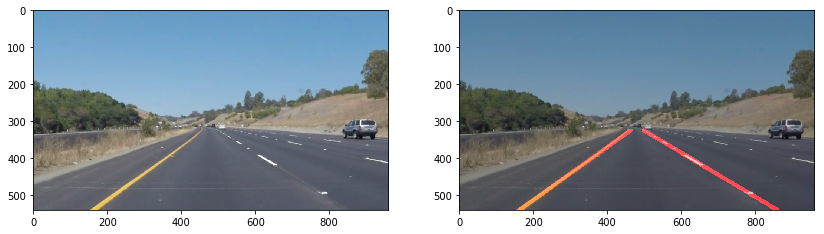

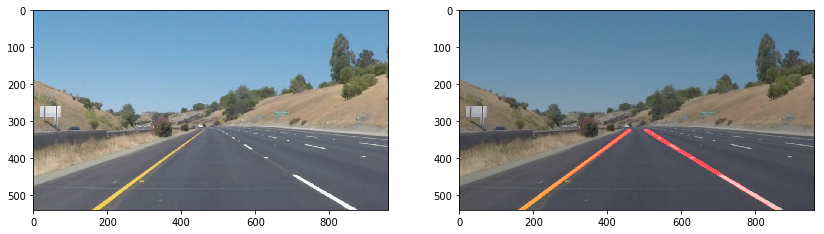

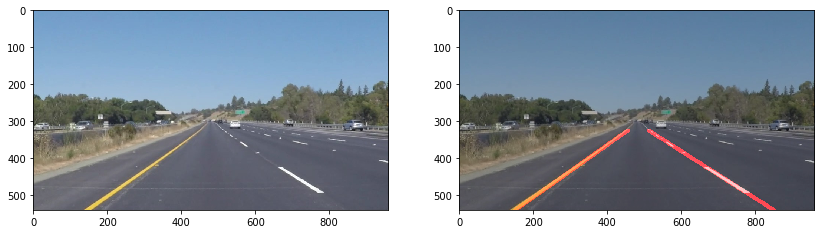

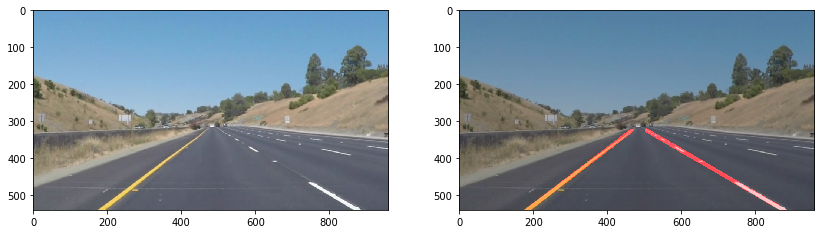

In [4]:
input_images = [mpimg.imread(i) for i in images]
result_images = [process_image(i)[-1] for i in input_images]
for i in range(len(result_images)):
    plt.figure(figsize=(14,10))
    
    # Display the original images
    plt.subplot(1, 2, 1)
    plt.imshow(input_images[i])
    
    # Display the processed images
    plt.subplot(1, 2, 2)
    plt.imshow(result_images[i])

## Run the process on the video files
The procedure will now be tested on the two project videos returning the averaged and extrapolated lines.

In [5]:
video_clips = [VideoFileClip(i) for i in videos]
video_process = lambda image: process_image(image)[-1]

for i in range(len(videos)-1):
    output = video_clips[i+1].fl_image(video_process)
    %time output.write_videofile(video_outputs[i+1])


[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing audio in solidWhiteRightTEMP_MPY_wvf_snd.mp3


100%|██████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 1736.44it/s]


[MoviePy] Done.
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:04<00:00, 45.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 5.28 s
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing audio in solidYellowLeftTEMP_MPY_wvf_snd.mp3


100%|██████████████████████████████████████████████████████████████████████████████| 601/601 [00:00<00:00, 2175.69it/s]


[MoviePy] Done.
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:15<00:00, 44.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 15.7 s


In [6]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_outputs[1]))

In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_outputs[2]))

## Challenge Video
Lastly the `process_image()` function will be used on the provided challenge video. Using the current procedure, showing the hough lines rather than the extrapolated and averaged lines is more informative. This video is included to highlight area's of improvement for the procedure.

In [8]:
video_process = lambda image: process_image(image)[-2]
output = video_clips[0].fl_image(video_process)
%time output.write_videofile(video_outputs[0])



[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing audio in challengeTEMP_MPY_wvf_snd.mp3


100%|██████████████████████████████████████████████████████████████████████████████| 222/222 [00:00<00:00, 1506.19it/s]


[MoviePy] Done.
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 25.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 10.6 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_outputs[0]))